In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
call_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/calls.csv')  # call_id, agent_id, call_duration, wait_time, call_reason_id
customer_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/customers.csv')  # call_id, customer_id, sentiment_score
reason_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/reason.csv')  # call_reason_id, call_reason_description
sentiment_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/sentiment_statistics.csv')  # call_id, sentiment

# Printing the columns of each dataframe to check if 'call_id' exists
print("Call data columns:", call_data.columns)
print("Customer data columns:", customer_data.columns)
print("Reason data columns:", reason_data.columns)
print("Sentiment data columns:", sentiment_data.columns)

Call data columns: Index(['call_id', 'customer_id', 'agent_id', 'call_start_datetime',
       'agent_assigned_datetime', 'call_end_datetime', 'call_transcript'],
      dtype='object')
Customer data columns: Index(['customer_id', 'customer_name', 'elite_level_code'], dtype='object')
Reason data columns: Index(['call_id', 'primary_call_reason'], dtype='object')
Sentiment data columns: Index(['call_id', 'agent_id', 'agent_tone', 'customer_tone',
       'average_sentiment', 'silence_percent_average'],
      dtype='object')


In [3]:
# Merging datasets
merged_data = pd.merge(call_data, customer_data, on='customer_id')
merged_data = pd.merge(merged_data, reason_data, on='call_id')
merged_data = pd.merge(merged_data, sentiment_data, on='call_id')

In [4]:
merged_data.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,963118,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,519057,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,158319,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,488324,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,721730,neutral,polite,-0.05,0.35


In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  66653 non-null  int64  
 1   customer_id              66653 non-null  int64  
 2   agent_id_x               66653 non-null  int64  
 3   call_start_datetime      66653 non-null  object 
 4   agent_assigned_datetime  66653 non-null  object 
 5   call_end_datetime        66653 non-null  object 
 6   call_transcript          66653 non-null  object 
 7   customer_name            66653 non-null  object 
 8   elite_level_code         42694 non-null  float64
 9   primary_call_reason      66653 non-null  object 
 10  agent_id_y               66653 non-null  int64  
 11  agent_tone               66455 non-null  object 
 12  customer_tone            66653 non-null  object 
 13  average_sentiment        66552 non-null  float64
 14  silence_percent_averag

In [6]:
# Assuming 'call_start_datetime' and 'call_end_datetime' are in datetime format
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])
merged_data['agent_assigned_datetime'] = pd.to_datetime(merged_data['agent_assigned_datetime'])

In [7]:
# Calculating Call Duration in seconds
merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

# Calculating Wait Time in seconds
merged_data['wait_time'] = (merged_data['agent_assigned_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

# Working with missing values

In [8]:
merged_data.isna().sum()

,0
call_id,0
customer_id,0
agent_id_x,0
call_start_datetime,0
agent_assigned_datetime,0
call_end_datetime,0
call_transcript,0
customer_name,0
elite_level_code,23959
primary_call_reason,0


In [9]:
print("Unique values of agent_tone:", merged_data['agent_tone'].unique())
print("Unique values of customer_tone:", merged_data['customer_tone'].unique())

Unique values of agent_tone: ['neutral' 'calm' 'frustrated' 'angry' nan 'polite']
Unique values of customer_tone: ['angry' 'neutral' 'polite' 'frustrated' 'calm']


In [10]:
# Filling NA values of agent_tone based on call_transcript using test analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_agent_tone(transcript):
  if not isinstance(transcript, str):
    return 'neutral'  # Default to neutral if transcript is not a string

  scores = analyzer.polarity_scores(transcript)
  compound_score = scores['compound']

  if compound_score >= 0.05:
    return 'polite'
  elif compound_score <= -0.05:
    if compound_score <= -0.5:
      return 'angry'
    else:
      return 'frustrated'
  else:
    return 'neutral'


# Filling NA values in 'agent_tone' based on transcript analysis
merged_data['agent_tone'] = merged_data.apply(lambda row: analyze_agent_tone(row['call_transcript']) if pd.isnull(row['agent_tone']) else row['agent_tone'], axis=1)
merged_data['agent_tone']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,agent_tone
0,neutral
1,calm
2,neutral
3,neutral
4,neutral
...,...
66648,neutral
66649,calm
66650,calm
66651,calm


In [11]:
# prompt: uniques values count of agent_tone
print(merged_data['agent_tone'].value_counts())

agent_tone
neutral       39688
calm          22882
frustrated     3438
angry           367
polite          278
Name: count, dtype: int64


In [12]:
# Grouping by 'agent_tone' and 'customer_tone' and calculate mean of 'average_sentiment'
merged_data['average_sentiment'] = np.random.rand(len(merged_data))
grouped_means = merged_data.groupby(['agent_tone', 'customer_tone'])['average_sentiment'].transform('mean')

# Filling NA values in 'average_sentiment' using the grouped means
merged_data['average_sentiment'].fillna(grouped_means)

,average_sentiment
0,0.310006
1,0.547671
2,0.485884
3,0.786076
4,0.770222
...,...
66648,0.472125
66649,0.468490
66650,0.921645
66651,0.641504


In [13]:
# prompt: no. of each uniques values of elite_level_code including NA value

print(merged_data['elite_level_code'].value_counts(dropna=False))


elite_level_code
NaN    23959
0.0    13338
1.0    13338
2.0     7468
3.0     5284
4.0     1961
5.0     1305
Name: count, dtype: int64


In [14]:
# prompt: fill na values of elite_level_code with mode

# Find the mode of 'elite_level_code'
elite_level_mode = merged_data['elite_level_code'].mode()[0]

# Fill NA values with the mode
merged_data['elite_level_code'].fillna(elite_level_mode, inplace=True)
merged_data['elite_level_code']

<ipython-input-14-fa4aaeef5001>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['elite_level_code'].fillna(elite_level_mode, inplace=True)


,elite_level_code
0,4.0
1,0.0
2,0.0
3,2.0
4,0.0
...,...
66648,2.0
66649,0.0
66650,1.0
66651,0.0


In [15]:
merged_data.isna().sum()

,0
call_id,0
customer_id,0
agent_id_x,0
call_start_datetime,0
agent_assigned_datetime,0
call_end_datetime,0
call_transcript,0
customer_name,0
elite_level_code,0
primary_call_reason,0


In [16]:
# Calculating AHT and AST
def calculate_aht(data):
    total_handle_time = data['call_duration'].sum()
    total_calls = len(data)
    aht = total_handle_time / total_calls
    return aht

def calculate_ast(data):
    total_waiting_time = data['wait_time'].sum()
    total_calls = len(data)
    ast = total_waiting_time / total_calls
    return ast

aht = calculate_aht(merged_data)
ast = calculate_ast(merged_data)

print(f"Average Handle Time (AHT): {aht:.2f} seconds")
print(f"Average Speed to Answer (AST): {ast:.2f} seconds")

Average Handle Time (AHT): 1134.15 seconds
Average Speed to Answer (AST): 436.97 seconds


# ---------- 3. AHT Analysis by Agent, Call Reason, and Sentiment ---------- #


Call Reason Distribution:
primary_call_reason
irrops                13311
voluntarychange       10848
seating                6365
mileageplus            5851
postflight             4330
communications         3840
products&services      3332
baggage                2832
upgrade                2738
booking                2637
checkin                1904
checkout               1888
voluntarycancel        1607
digitalsupport         1225
etc                     952
travelerupdates         937
othertopics             818
schedulechange          731
disability              403
unaccompaniedminor      104
Name: count, dtype: int64


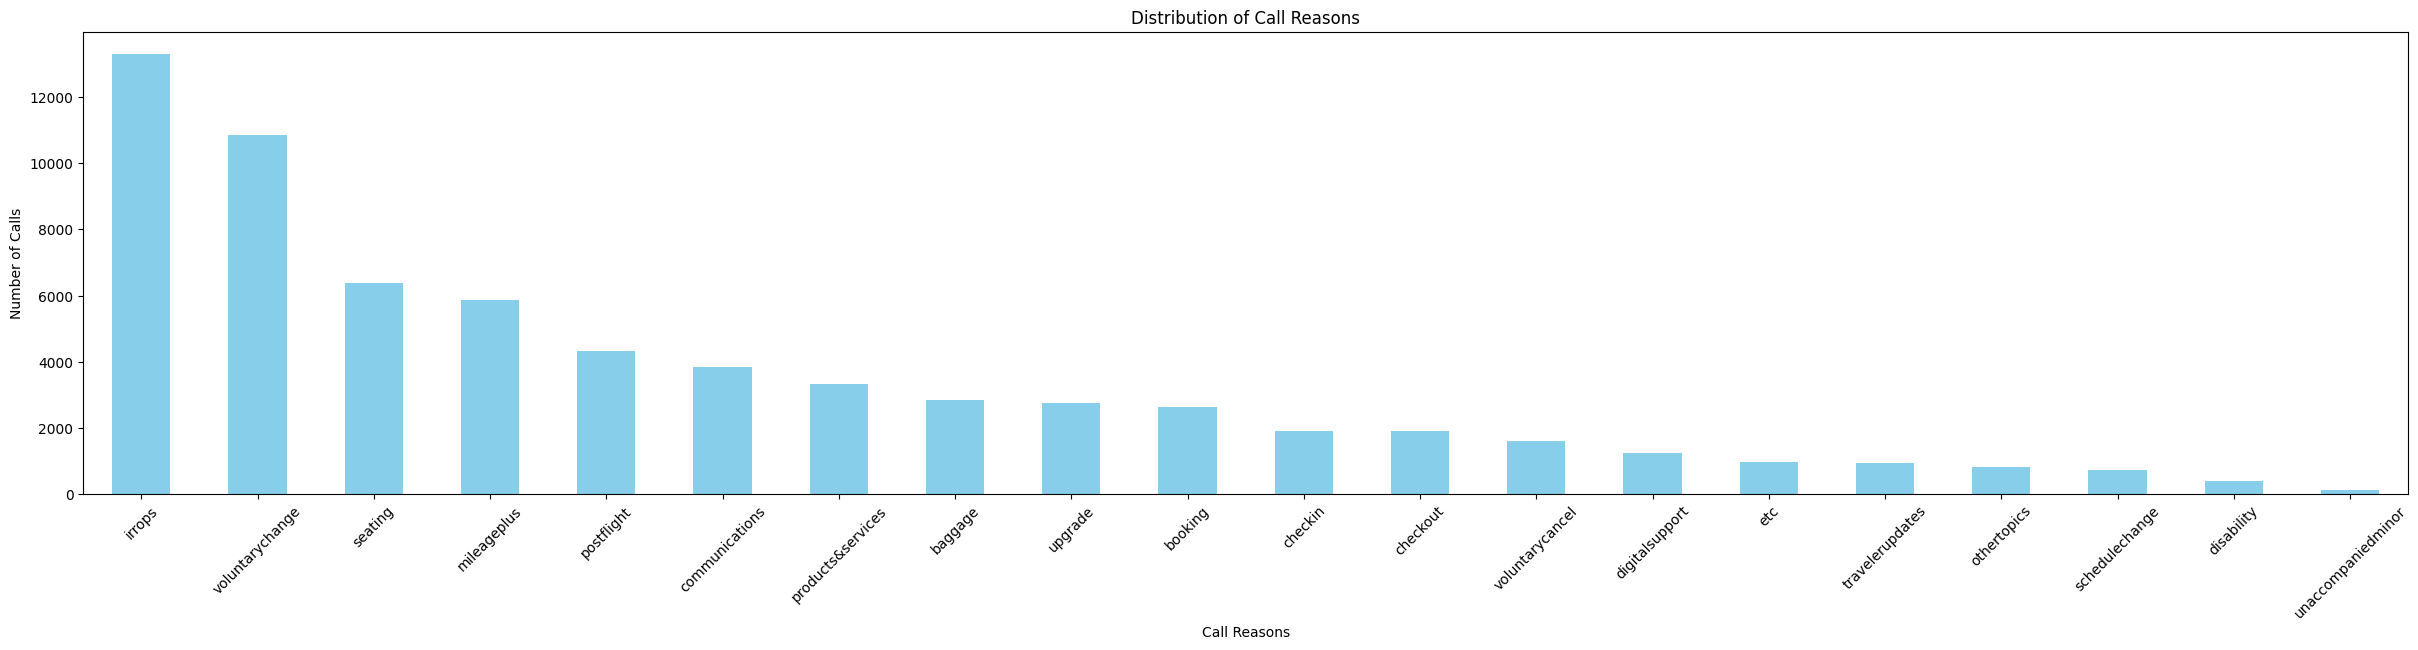

In [17]:
# Explore call reason distribution
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.strip()  # Remove extra spaces
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace(' ', '_').str.lower() # Replace space with underscore
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('_', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('__', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('___', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('-', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('and', '&')

call_reason_counts = merged_data['primary_call_reason'].value_counts()
print("Call Reason Distribution:")
print(call_reason_counts)

# Visualizing call reasons
plt.figure(figsize=(30, 6))
call_reason_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Call Reasons')
plt.xlabel('Call Reasons')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.show()

AHT by Call Reason:
   primary_call_reason  avg_handle_time
0              baggage       875.741525
1              booking       667.963595
2              checkin       929.968487
3             checkout      1741.557203
4       communications      1066.687500
5       digitalsupport       878.008163
6           disability       795.632754
7                  etc      1507.184874
8               irrops      1145.197205
9          mileageplus      1356.588617
10         othertopics       588.850856
11          postflight      1502.327945
12   products&services      1049.009604
13      schedulechange       730.834473
14             seating      1045.819324
15     travelerupdates      1083.265742
16  unaccompaniedminor      1207.500000
17             upgrade       930.832725
18     voluntarycancel      1261.381456
19     voluntarychange      1179.640487


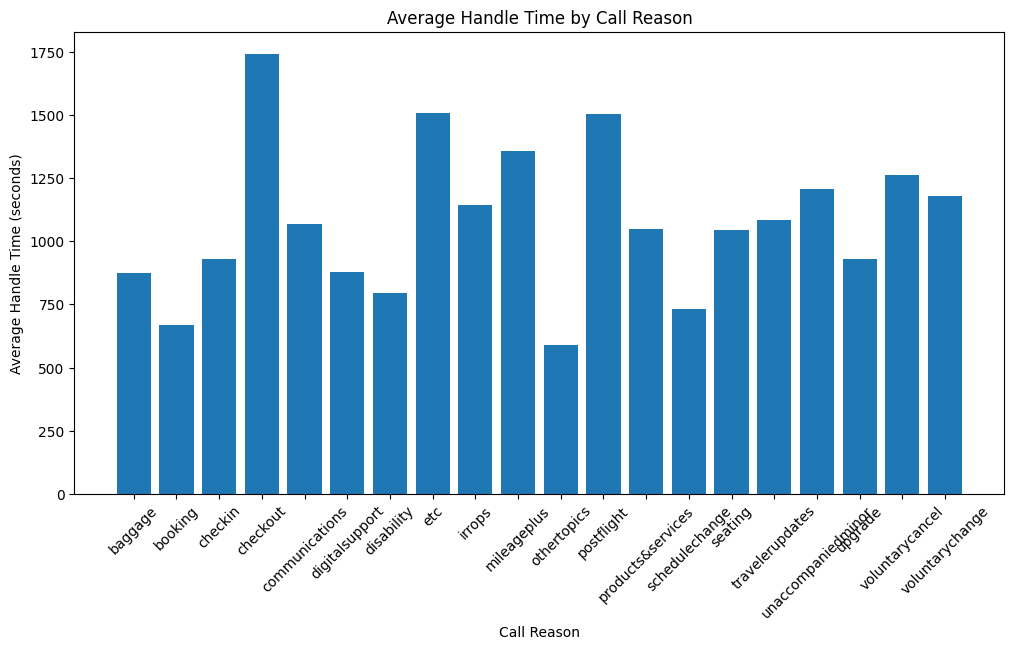

In [18]:
# AHT by call reason
aht_by_call_reason = merged_data.groupby('primary_call_reason')['call_duration'].mean().reset_index()
aht_by_call_reason.columns = ['primary_call_reason', 'avg_handle_time']
print("AHT by Call Reason:")
print(aht_by_call_reason)

# Plotting AHT by Call Reason using a bar chart for better visualization
plt.figure(figsize=(12, 6))
plt.bar(aht_by_call_reason['primary_call_reason'], aht_by_call_reason['avg_handle_time'])
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (seconds)')
plt.title('Average Handle Time by Call Reason')
plt.xticks(rotation=45)
plt.show()

AHT by Agent:
     agent_id_x  avg_handle_time
0        102574      4080.000000
1        103651      1163.745583
2        106000      1164.356436
3        107876      1460.000000
4        112609      1447.500000
..          ...              ...
378      981776      1132.928571
379      981779      1137.746479
380      982131      1173.571429
381      992521      1437.209302
382      993862      1116.739130

[383 rows x 2 columns]


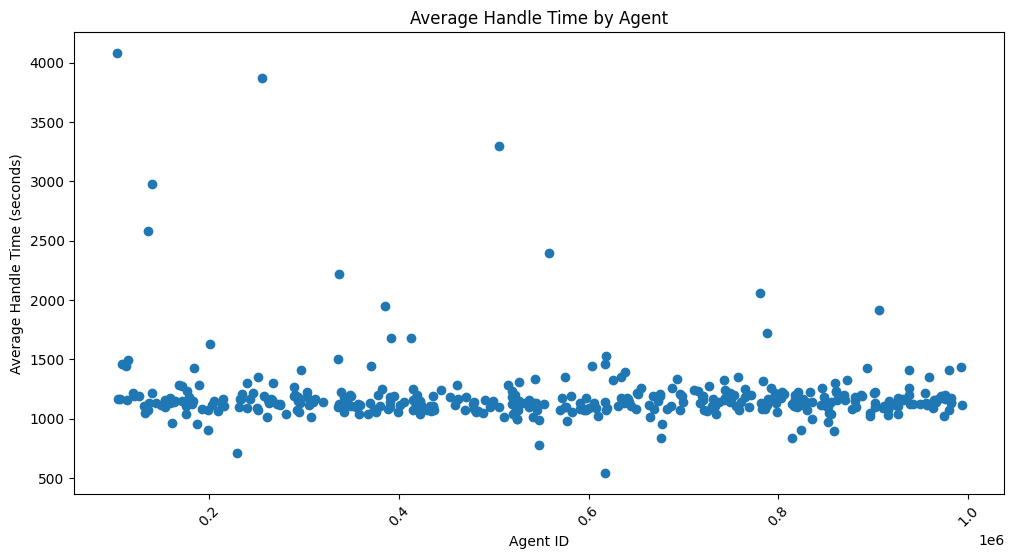

In [19]:
# AHT by agent
aht_by_agent = merged_data.groupby('agent_id_x')['call_duration'].mean().reset_index()
aht_by_agent.columns = ['agent_id_x', 'avg_handle_time']
print("AHT by Agent:")
print(aht_by_agent)

# Plotting AHT by Agent using a scatter plot for better visualization
plt.figure(figsize=(12, 6))
plt.scatter(aht_by_agent['agent_id_x'], aht_by_agent['avg_handle_time'])
plt.xlabel('Agent ID')
plt.ylabel('Average Handle Time (seconds)')
plt.title('Average Handle Time by Agent')
plt.xticks(rotation=45)
plt.show()

#AST Analysis by Agent, Call Reason, and Sentiment

AST by Call Reason:
   primary_call_reason  avg_speed_to_answer
0              baggage           542.097458
1              booking           240.227531
2              checkin           355.840336
3             checkout           724.703390
4       communications           239.968750
5       digitalsupport           505.714286
6           disability           503.523573
7                  etc           544.285714
8               irrops           360.081136
9          mileageplus           361.015211
10         othertopics           238.753056
11          postflight           569.431871
12   products&services           302.448980
13      schedulechange           240.820793
14             seating           570.824823
15     travelerupdates           690.032017
16  unaccompaniedminor           688.269231
17             upgrade           298.487947
18     voluntarycancel           539.514624
19     voluntarychange           540.486726


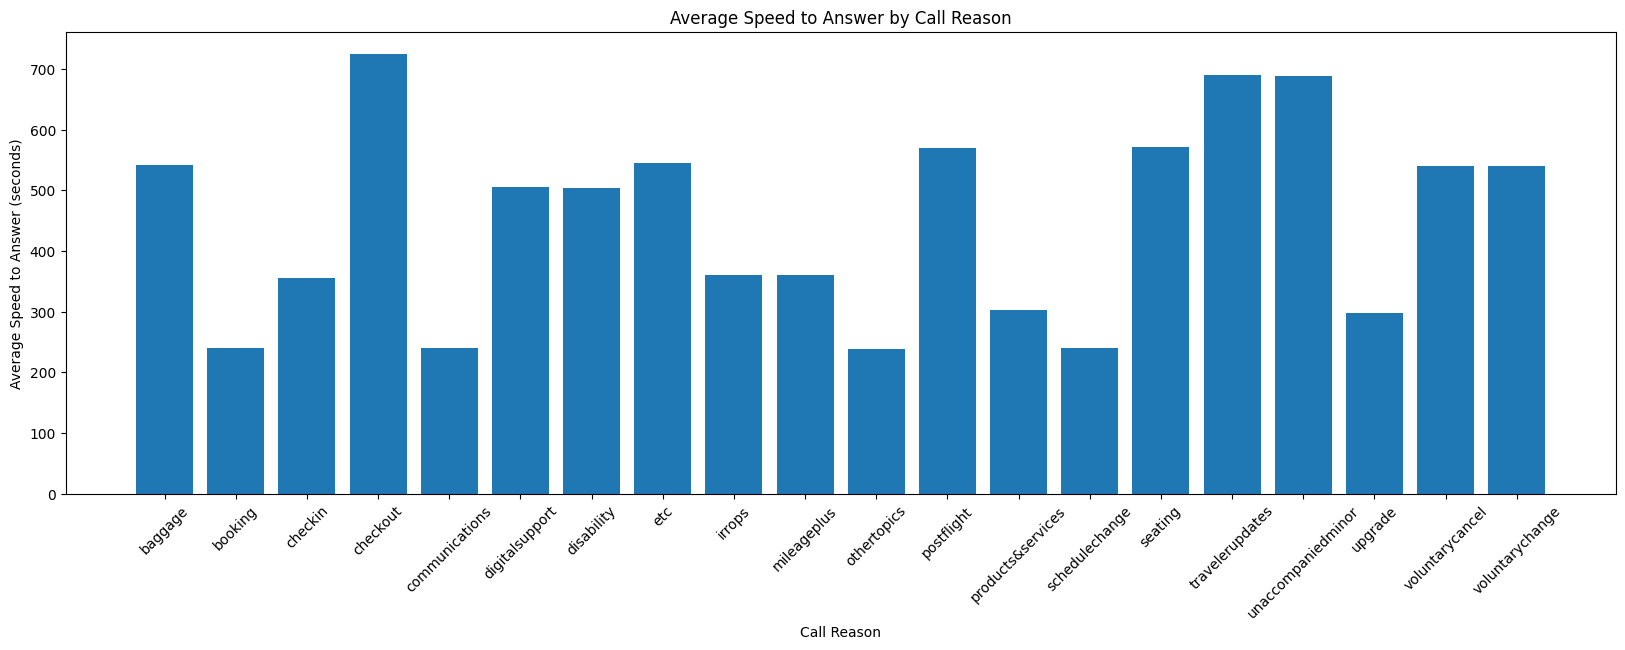

In [20]:
# AST by call reason
ast_by_call_reason = merged_data.groupby('primary_call_reason')['wait_time'].mean().reset_index()
ast_by_call_reason.columns = ['primary_call_reason', 'avg_speed_to_answer']
print("AST by Call Reason:")
print(ast_by_call_reason)

# Plotting AST by Call Reason using a bar chart for better visualization
plt.figure(figsize=(20, 6))
plt.bar(ast_by_call_reason['primary_call_reason'], ast_by_call_reason['avg_speed_to_answer'])
plt.xlabel('Call Reason')
plt.ylabel('Average Speed to Answer (seconds)')
plt.title('Average Speed to Answer by Call Reason')
plt.xticks(rotation=45)
plt.show()

AST by Agent:
     agent_id_x  avg_speed_to_answer
0        102574           480.000000
1        103651           419.575972
2        106000           441.980198
3        107876           470.000000
4        112609           435.000000
..          ...                  ...
378      981776           427.071429
379      981779           439.718310
380      982131           439.285714
381      992521           453.488372
382      993862           440.652174

[383 rows x 2 columns]


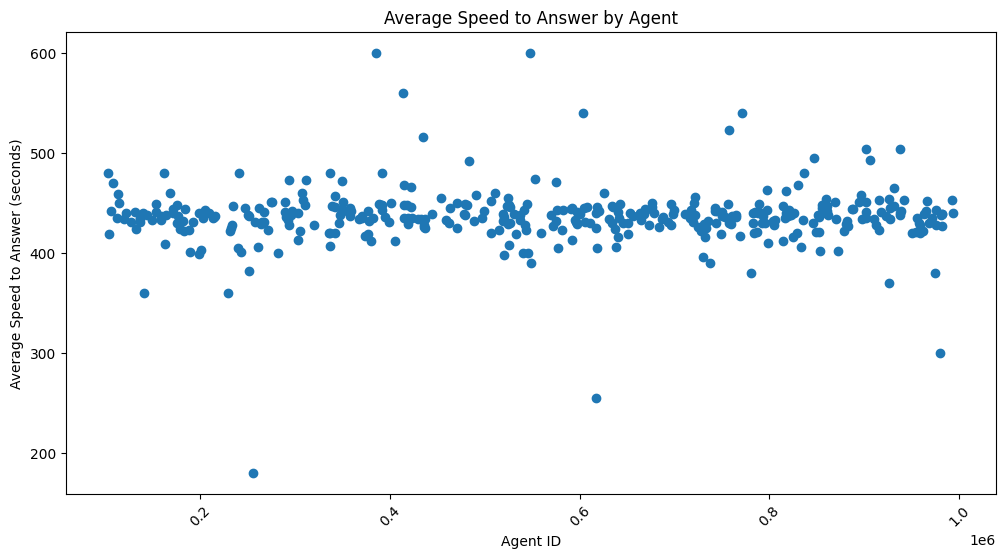

In [21]:
# AST by agent
ast_by_agent = merged_data.groupby('agent_id_x')['wait_time'].mean().reset_index()
ast_by_agent.columns = ['agent_id_x', 'avg_speed_to_answer']
print("AST by Agent:")
print(ast_by_agent)

# Plotting AST by Agent using a scatter plot for better visualization
plt.figure(figsize=(12, 6))
plt.scatter(ast_by_agent['agent_id_x'], ast_by_agent['avg_speed_to_answer'])
plt.xlabel('Agent ID')
plt.ylabel('Average Speed to Answer (seconds)')
plt.title('Average Speed to Answer by Agent')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Calculate average speed to answer by sentiment
ast_by_sentiment = merged_data.groupby('average_sentiment')['wait_time'].mean().reset_index()
ast_by_sentiment.columns = ['average_sentiment', 'avg_speed_to_answer']

# Calculate correlation between sentiment and wait time
correlation = merged_data['average_sentiment'].corr(merged_data['wait_time'])
print(f"Correlation between sentiment and wait time: {correlation:.2f}")

Correlation between sentiment and wait time: -0.00


## Percentage Difference for AHT

In [62]:
# Grouping by Call Reason and Calculate AHT
aht_by_reason = merged_data.groupby('primary_call_reason')['call_duration'].mean()

# Identifying Most and Least Frequent Call Reasons
freq_by_reason = merged_data['primary_call_reason'].value_counts()
most_frequent_reason = freq_by_reason.idxmax()
least_frequent_reason = freq_by_reason.idxmin()

# AHT for Most and Least Frequent Call Reasons
most_frequent_aht = aht_by_reason[most_frequent_reason]
least_frequent_aht = aht_by_reason[least_frequent_reason]

# Percentage difference in AHT
aht_diff_percentage = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100
print(aht_diff_percentage)

-5.159651733423664


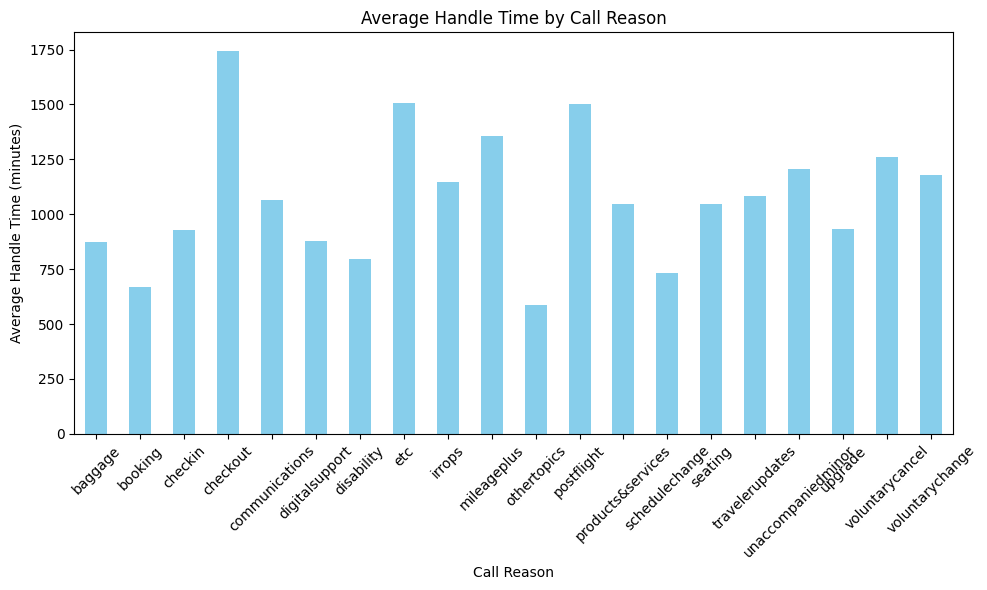

{'Most Frequent Reason': 'irrops',
 'Least Frequent Reason': 'unaccompaniedminor',
 'AHT Most Frequent': 1145.1972053189093,
 'AHT Least Frequent': 1207.5,
 'AHT Difference (%)': -5.159651733423664,
 'Descriptive Statistics':                        count         mean         std    min     25%     50%  \
 primary_call_reason                                                            
 baggage               2832.0   875.741525  405.368183  420.0   660.0   780.0   
 booking               2637.0   667.963595  567.255447  180.0   360.0   480.0   
 checkin               1904.0   929.968487  859.724136  240.0   540.0   660.0   
 checkout              1888.0  1741.557203  963.801820  540.0  1140.0  1500.0   
 communications        3840.0  1066.687500  834.795563  180.0   540.0   780.0   
 digitalsupport        1225.0   878.008163  431.980486  420.0   660.0   780.0   
 disability             403.0   795.632754  314.623338  420.0   600.0   720.0   
 etc                    952.0  1507.184874  97

In [24]:
# Descriptive Statistics
descriptive_stats = merged_data.groupby('primary_call_reason')['call_duration'].describe()

# Visualization
plt.figure(figsize=(10, 6))
aht_by_reason.plot(kind='bar', color='skyblue')
plt.title('Average Handle Time by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output results
results_aht = {
    'Most Frequent Reason': most_frequent_reason,
    'Least Frequent Reason': least_frequent_reason,
    'AHT Most Frequent': most_frequent_aht,
    'AHT Least Frequent': least_frequent_aht,
    'AHT Difference (%)': aht_diff_percentage,
    'Descriptive Statistics': descriptive_stats
}

results_aht

## Percentage Difference for AST

In [63]:
# Grouping by Call Reason and Calculate AST
ast_by_reason = merged_data.groupby('primary_call_reason')['wait_time'].mean()

# Identifying Most and Least Frequent Call Reasons
frequency_by_reason = merged_data['primary_call_reason'].value_counts()
most_freq_reason = frequency_by_reason.idxmax()
least_freq_reason = frequency_by_reason.idxmin()

# AST for Most and Least Frequent Call Reasons
most_frequent_ast = ast_by_reason[most_freq_reason]
least_frequent_ast = ast_by_reason[least_freq_reason]

# Percentage difference in AST
ast_diff_percentage = ((most_frequent_ast - least_frequent_ast) / least_frequent_ast) * 100
print(ast_diff_percentage)

-47.683098443875046


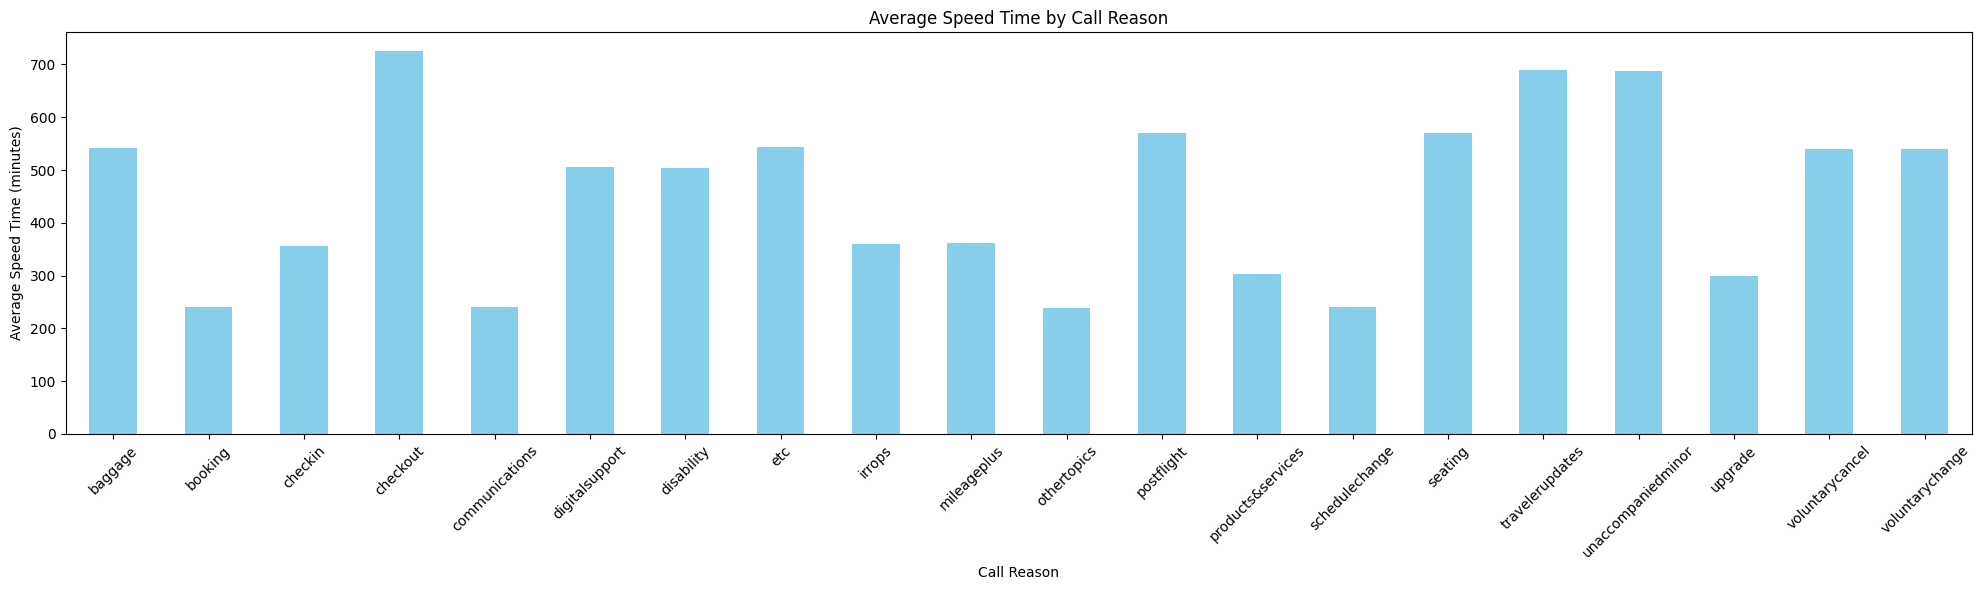

{'Most Frequent Reason': 'irrops',
 'Least Frequent Reason': 'unaccompaniedminor',
 'AHT Most Frequent': 360.0811359026369,
 'AHT Least Frequent': 688.2692307692307,
 'AHT Difference (%)': -47.683098443875046,
 'Descriptive Statistics':                        count        mean         std    min    25%    50%  \
 primary_call_reason                                                         
 baggage               2832.0  542.097458   86.128598  420.0  480.0  540.0   
 booking               2637.0  240.227531   49.276493  180.0  180.0  240.0   
 checkin               1904.0  355.840336   85.240396  240.0  300.0  360.0   
 checkout              1888.0  724.703390  119.093542  540.0  600.0  720.0   
 communications        3840.0  239.968750   49.263384  180.0  180.0  240.0   
 digitalsupport        1225.0  505.714286   68.082994  420.0  420.0  480.0   
 disability             403.0  503.523573   67.185725  420.0  420.0  480.0   
 etc                    952.0  544.285714   82.572431  420.0  

In [26]:
# Descriptive Statistics
desc_stats = merged_data.groupby('primary_call_reason')['wait_time'].describe()

# Visualization
plt.figure(figsize=(20, 6))
ast_by_reason.plot(kind='bar', color='skyblue')
plt.title('Average Speed Time by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Speed Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output results
results_ast = {
    'Most Frequent Reason': most_freq_reason,
    'Least Frequent Reason': least_freq_reason,
    'AHT Most Frequent': most_frequent_ast,
    'AHT Least Frequent': least_frequent_ast,
    'AHT Difference (%)': ast_diff_percentage,
    'Descriptive Statistics': desc_stats
}

results_ast

# IVR RECCOMENDATION

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Keyword Extraction from Call Transcripts
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(merged_data['call_transcript'])
keywords = vectorizer.get_feature_names_out()
keyword_counts = pd.DataFrame(X.toarray(), columns=keywords)

# Step 2: Sentiment and Tone Analysis
sentiment_by_reason = merged_data.groupby('primary_call_reason')['average_sentiment'].mean()
tone_analysis = merged_data.groupby('primary_call_reason')[['customer_tone', 'agent_tone']].agg(lambda x: x.mode()[0] if not x.empty else None)

In [28]:
# Silence Analysis
silence_analysis = merged_data.groupby('primary_call_reason')['silence_percent_average'].mean().sort_values(ascending=False)

# Step 3: Call Volume Analysis
call_volume_by_reason = merged_data['primary_call_reason'].value_counts()

# Step 4: Create IVR Prioritization System
ivr_prioritization = pd.DataFrame({
    'Call Reason': call_volume_by_reason.index,
    'Call Volume': call_volume_by_reason.values,
    'Average Sentiment': sentiment_by_reason,
    'Average Silence': merged_data.groupby('primary_call_reason')['silence_percent_average'].mean()
})

In [29]:
# Calculate prioritization score (higher score = higher priority)
ivr_prioritization['Prioritization Score'] = (
    ivr_prioritization['Call Volume'] * 0.5 +  # Higher volume gets more weight
    (1 - ivr_prioritization['Average Sentiment']) * 0.3 +  # Lower sentiment gets more weight
    ivr_prioritization['Average Silence'] * 0.2  # Higher silence gets more weight
)

# Sort by prioritization score
ivr_prioritization = ivr_prioritization.sort_values('Prioritization Score', ascending=False)

# Display IVR Prioritization
print("\nIVR Prioritization:")
print(ivr_prioritization)


IVR Prioritization:
                            Call Reason  Call Volume  Average Sentiment  \
primary_call_reason                                                       
baggage                          irrops        13311           0.493760   
booking                 voluntarychange        10848           0.496667   
checkin                         seating         6365           0.502054   
checkout                    mileageplus         5851           0.504085   
communications               postflight         4330           0.500626   
digitalsupport           communications         3840           0.500737   
disability            products&services         3332           0.498359   
etc                             baggage         2832           0.511608   
irrops                          upgrade         2738           0.499452   
mileageplus                     booking         2637           0.500148   
othertopics                     checkin         1904           0.502625   
post

In [30]:
# Step 5: Refine IVR Workflow based on Extracted Keywords
billing_keywords = ['bill', 'payment', 'due', 'invoice', 'charge']

def create_ivr_workflow(reason, keywords):
    """Creates a basic IVR workflow based on call reason and keywords."""
    if reason == 'billing':
        print("\nIVR Workflow for Billing:")
        print("1. Welcome message.")
        print("2. Main menu options:")
        print("   - Check bill balance.")
        print("   - Make a payment.")
        print("   - Dispute a charge.")
        print("   - Speak to a representative.")
        print("3. Keyword-based routing (e.g., if 'payment' is detected, route to payment section).")

# Apply the workflow for billing if present in the prioritization
if 'billing' in ivr_prioritization['Call Reason'].values:
    create_ivr_workflow('billing', billing_keywords)

In [31]:
# Step 6: Refine IVR Recommendations based on Prioritization and Patterns

# Predefined IVR menu options
ivr_recommendations_static = {
    'Baggage': 'Press 1 for self-service baggage tracking.',
    'Booking': 'Press 2 to modify or confirm your booking. You can also say "change booking".',
    'Check-In': 'Press 3 to complete your check-in process.',
    'MileagePlus': 'Press 4 to check your points or upgrade eligibility.',
    'Schedule Change': 'Press 5 to reschedule your flight after a schedule change.',
    'Voluntary Cancellation': 'We understand cancellations can be frustrating. Press 6 to cancel, or say "agent" to speak directly with a representative.',
    'Upgrade': 'Press 7 for self-service upgrade options or eligibility checks.',
    'Post-Flight Issues': 'Press 8 to raise any post-flight issues or feedback.',
    'Disability Support': 'For special services, press 9 and we’ll connect you with an agent immediately.'
}

In [32]:
# Dynamic IVR recommendation generation
def generate_ivr_recommendation(reason, sentiment, silence, score):
    """Generate IVR recommendation based on sentiment, silence, and prioritization score."""
    recommendation = ""

    # Common self-service options for frequent, simple inquiries
    if score > 0.5:  # Higher prioritization score
        if reason in ['baggage', 'booking', 'checkin', 'checkout', 'digitalsupport']:
            recommendation += f"Offer a self-service option for {reason} queries. "
        if reason in ['postflight', 'voluntarycancel', 'voluntarychange']:
            recommendation += f"Provide automated status checks for {reason}. "

    # High silence means possible self-solvable issues
    if silence > 0.5:
        recommendation += f"High silence detected in {reason} calls. Consider IVR for {reason} queries to reduce call time. "

    # Low sentiment indicates potential frustration
    if sentiment < 0.5:
        recommendation += f"Low sentiment detected for {reason} queries. Automate steps to resolve common complaints. "

    # Add fallback to agent
    recommendation += "Always offer an option to speak to an agent if IVR does not resolve the issue."

    return recommendation


In [33]:
# Iterate through the prioritization DataFrame and generate dynamic recommendations
ivr_recommendations_dynamic = {}
for index, row in ivr_prioritization.iterrows():
    reason = row['Call Reason']
    sentiment = row['Average Sentiment']
    silence = row['Average Silence']
    score = row['Prioritization Score']

    recommendation = generate_ivr_recommendation(reason, sentiment, silence, score)
    ivr_recommendations_dynamic[reason] = recommendation


In [34]:
# Combine static and dynamic recommendations
def combine_static_dynamic_recommendations(reason):
    """Combines static IVR menu options with dynamic recommendations."""
    static_recommendation = ivr_recommendations_static.get(reason, "")
    dynamic_recommendation = ivr_recommendations_dynamic.get(reason, "")

    if static_recommendation and dynamic_recommendation:
        return f"{static_recommendation} Additionally: {dynamic_recommendation}"
    elif static_recommendation:
        return static_recommendation
    elif dynamic_recommendation:
        return dynamic_recommendation
    else:
        return "No specific recommendation available."


In [35]:
# Output the combined IVR recommendations
print("\nCombined IVR Recommendations:")
for reason in ivr_prioritization['Call Reason']:
    combined_recommendation = combine_static_dynamic_recommendations(reason)
    print(f"{reason}: {combined_recommendation}")


Combined IVR Recommendations:
irrops: Low sentiment detected for irrops queries. Automate steps to resolve common complaints. Always offer an option to speak to an agent if IVR does not resolve the issue.
voluntarychange: Provide automated status checks for voluntarychange. Low sentiment detected for voluntarychange queries. Automate steps to resolve common complaints. Always offer an option to speak to an agent if IVR does not resolve the issue.
seating: Always offer an option to speak to an agent if IVR does not resolve the issue.
mileageplus: Always offer an option to speak to an agent if IVR does not resolve the issue.
postflight: Provide automated status checks for postflight. Always offer an option to speak to an agent if IVR does not resolve the issue.
communications: Always offer an option to speak to an agent if IVR does not resolve the issue.
products&services: Low sentiment detected for products&services queries. Automate steps to resolve common complaints. Always offer an 

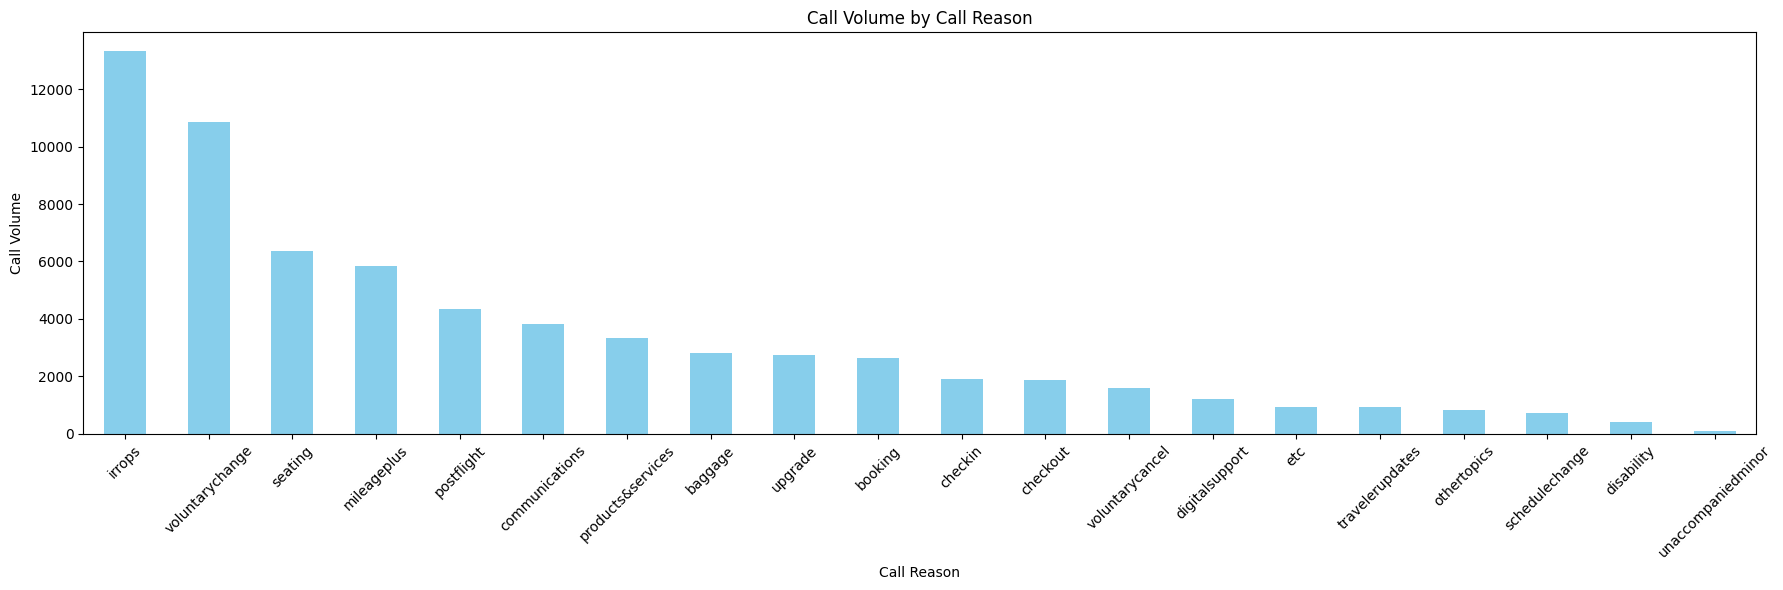

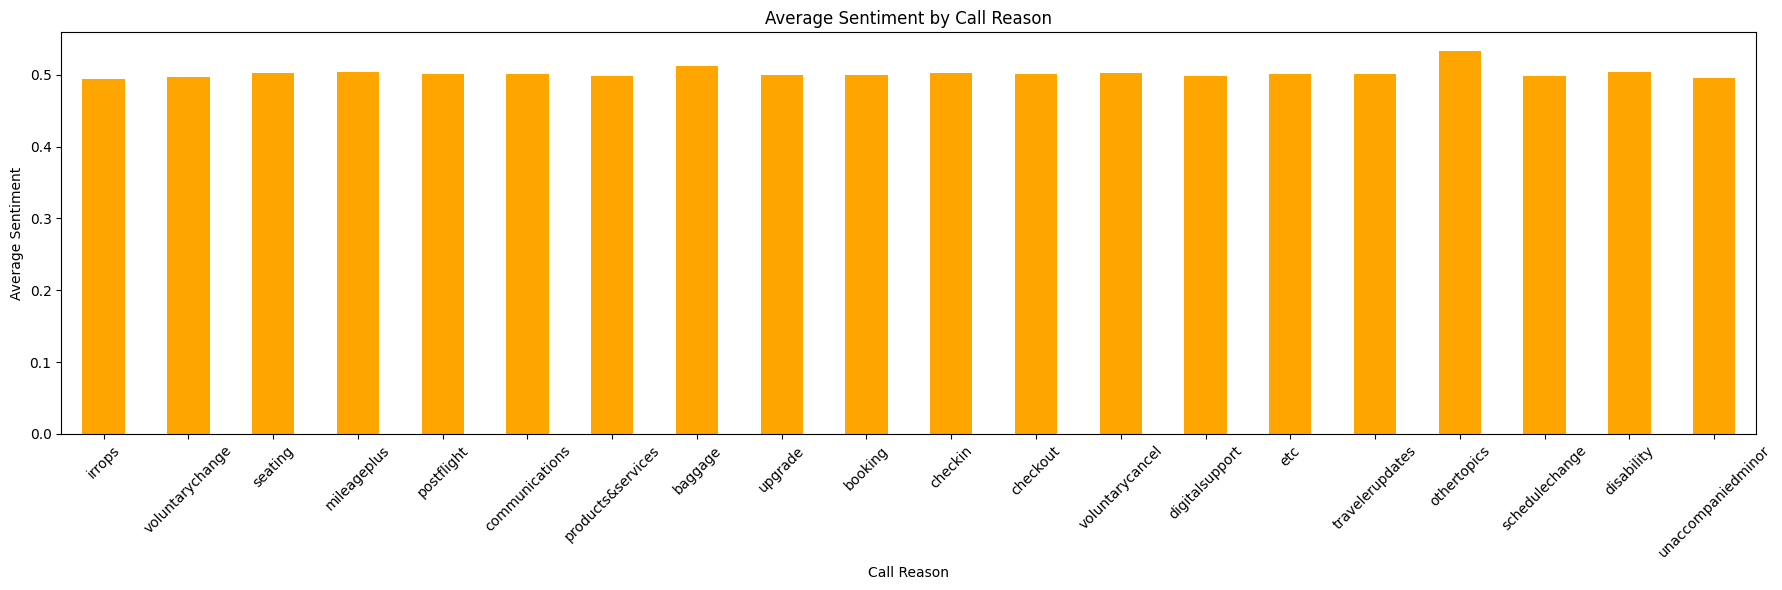

In [36]:
# Optional: Visualize Sentiment and Call Volume
plt.figure(figsize=(18, 6))
ivr_prioritization.set_index('Call Reason')['Call Volume'].plot(kind='bar', color='skyblue')
plt.title('Call Volume by Call Reason')
plt.ylabel('Call Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
ivr_prioritization.set_index('Call Reason')['Average Sentiment'].plot(kind='bar', color='orange')
plt.title('Average Sentiment by Call Reason')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Prediction of Call Reasons


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from joblib import Parallel, delayed

# Download NLTK stopwords if you haven't already
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# Set stopwords as a set for faster lookup
stop_words = set(stopwords.words('english'))

# Preprocess function with optimized stopwords check
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_words)

# Parallelize the application of the preprocessing function using joblib
def preprocess_dataset(data, num_cores=4):
    processed_text = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in data)
    return processed_text

# Apply the preprocess function to the call transcripts
merged_data['clean_transcript'] = preprocess_dataset(merged_data['call_transcript'].tolist())

In [39]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(merged_data['clean_transcript'])

# Combine numerical features with text features
X_numerical = merged_data[['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']]
X = np.hstack((X_text.toarray(), X_numerical))

# Target variable
y = merged_data['primary_call_reason']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Create and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.36133823419098343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

           baggage       0.33      0.00      0.00       604
           booking       0.28      0.22      0.25       513
           checkin       0.00      0.00      0.00       359
          checkout       0.87      0.52      0.65       384
    communications       0.34      0.13      0.19       757
    digitalsupport       0.00      0.00      0.00       255
        disability       0.00      0.00      0.00        86
               etc       0.00      0.00      0.00       197
            irrops       0.35      0.94      0.51      2763
       mileageplus       0.20      0.02      0.04      1130
       othertopics       0.00      0.00      0.00       174
        postflight       0.38      0.20      0.26       848
 products&services       0.07      0.00      0.00       658
    schedulechange       0.00      0.00      0.00       146
           seating       0.39      0.65      0.48      1235
   travelerupdates       0.91      0.05

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# prompt: simple logistics regression model

# Create and train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print(classification_report(y_test, y_pred_logreg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.29615182656964967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

           baggage       0.00      0.00      0.00       604
           booking       0.00      0.00      0.00       513
           checkin       0.00      0.00      0.00       359
          checkout       0.00      0.00      0.00       384
    communications       0.65      0.02      0.03       757
    digitalsupport       0.00      0.00      0.00       255
        disability       0.00      0.00      0.00        86
               etc       0.00      0.00      0.00       197
            irrops       0.32      0.83      0.46      2763
       mileageplus       0.20      0.03      0.06      1130
       othertopics       0.00      0.00      0.00       174
        postflight       0.28      0.02      0.04       848
 products&services       0.00      0.00      0.00       658
    schedulechange       0.00      0.00      0.00       146
           seating       0.00      0.00      0.00      1235
   travelerupdates       0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# prompt: which will be the better model among the above

# Compare the accuracy of the two models
if accuracy > accuracy_logreg:
  print("Random Forest model is better with accuracy:", accuracy)
else:
  print("Logistic Regression model is better with accuracy:", accuracy_logreg)


Random Forest model is better with accuracy: 0.36133823419098343


In [56]:
import pandas as pd
import numpy as np

# Load the new test data
test_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/test.csv')

# Merge the test data with the combined dataset to get the call_transcript
# Assuming call_data is your original merged_data DataFrame
test_combined = pd.merge(test_data, merged_data[['call_id', 'call_transcript', 'call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']], on='call_id', how='left')

# Check if the call_transcript is available
if test_combined['call_transcript'].isnull().any():
    print("Warning: Some call_transcripts are missing in the test data after merging.")

# Preprocess the test data (clean transcripts)
# Convert 'call_transcript' to string and fill NaNs with empty string
test_combined['call_transcript'] = test_combined['call_transcript'].astype(str).fillna('')
test_combined['clean_transcript'] = preprocess_dataset(test_combined['call_transcript'].tolist())

# Vectorize the cleaned transcripts
X_test_transcripts = vectorizer.transform(test_combined['clean_transcript'])

# Combine the TF-IDF features with the numerical features
X_test_numerical = test_combined[['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']].fillna(0)

# Combine text features and numerical features
X_test_combined = np.hstack((X_test_transcripts.toarray(), X_test_numerical))

# Predict the primary call reason for the test set
test_combined['primary_call_reason'] = rf_model.predict(X_test_combined)

# Save the predictions for submission
submission = test_combined[['call_id', 'primary_call_reason']]
submission.to_csv('/content/drive/MyDrive/assignments/Skyhack/test_result.csv', index=False)
print("Test predictions saved to /content/drive/MyDrive/assignments/Skyhack/test_result.csv")


Test predictions saved to /content/drive/MyDrive/assignments/Skyhack/test_result.csv


In [58]:
print(merged_data['primary_call_reason'].value_counts())

from sklearn.metrics import classification_report

y_train_pred = rf_model.predict(X_train)
print(classification_report(y_train, y_train_pred))

importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': np.concatenate([feature_names, ['call_duration', 'wait_time', 'average_sentiment', 'silence_percent_average']]), 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)


primary_call_reason
irrops                13311
voluntarychange       10848
seating                6365
mileageplus            5851
postflight             4330
communications         3840
products&services      3332
baggage                2832
upgrade                2738
booking                2637
checkin                1904
checkout               1888
voluntarycancel        1607
digitalsupport         1225
etc                     952
travelerupdates         937
othertopics             818
schedulechange          731
disability              403
unaccompaniedminor      104
Name: count, dtype: int64
                    precision    recall  f1-score   support

           baggage       1.00      1.00      1.00      2228
           booking       1.00      1.00      1.00      2124
           checkin       1.00      1.00      1.00      1545
          checkout       1.00      1.00      1.00      1504
    communications       1.00      1.00      1.00      3083
    digitalsupport       1.00    

In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)


Cross-validation scores: [0.34280356 0.34889827 0.34939985 0.34714929 0.35371343]


In [61]:
# Inspect the test dataset
print(test_combined.head())
print(test_combined.describe())

      call_id call_transcript  call_duration  wait_time  average_sentiment  \
0  7732610078             nan            NaN        NaN                NaN   
1  2400299738             nan            NaN        NaN                NaN   
2  6533095063             nan            NaN        NaN                NaN   
3  7774450920             nan            NaN        NaN                NaN   
4  9214147168             nan            NaN        NaN                NaN   

   silence_percent_average clean_transcript primary_call_reason  
0                      NaN              nan             booking  
1                      NaN              nan             booking  
2                      NaN              nan             booking  
3                      NaN              nan             booking  
4                      NaN              nan             booking  
            call_id  call_duration  wait_time  average_sentiment  \
count  5.157000e+03            0.0        0.0                0.0   